# NEM demand from `NEMOSIS`

In [1]:
import pandas as pd

import glob

### Open demand data

In [2]:
data_path = "/g/data/w42/dr6273/tmp/"

In [3]:
files = sorted(glob.glob(data_path+"*TRADING*.CSV")) # TRADING is for 30min demand
files[:3]

['/g/data/w42/dr6273/tmp/PUBLIC_DVD_TRADINGREGIONSUM_200912010000.CSV',
 '/g/data/w42/dr6273/tmp/PUBLIC_DVD_TRADINGREGIONSUM_201001010000.CSV',
 '/g/data/w42/dr6273/tmp/PUBLIC_DVD_TRADINGREGIONSUM_201002010000.CSV']

In [5]:
def open_df(path):
    return pd.read_csv(
        path,
        header=1,
        usecols=["REGIONID", "SETTLEMENTDATE", "TOTALDEMAND"],
        parse_dates=["SETTLEMENTDATE"],
        index_col="SETTLEMENTDATE",
    )

In [8]:
dfs = [open_df(f) for f in files]

In [74]:
df = pd.concat(dfs)

Remove NaNs

In [80]:
df.loc[df.REGIONID.isnull()].head()

,REGIONID,TOTALDEMAND
SETTLEMENTDATE,,
NaT,NaN,NaN
NaT,NaN,NaN
NaT,NaN,NaN
NaT,NaN,NaN
NaT,NaN,NaN


In [81]:
df = df.loc[~df.REGIONID.isnull()]

In [82]:
df

,REGIONID,TOTALDEMAND
SETTLEMENTDATE,,
2009-12-01 00:30:00,NSW1,7506.77
2009-12-01 00:30:00,QLD1,5723.40
2009-12-01 00:30:00,SA1,1361.08
2009-12-01 00:30:00,TAS1,1041.04
2009-12-01 00:30:00,VIC1,4860.18
...,...,...
2021-02-01 00:00:00,NSW1,6855.82
2021-02-01 00:00:00,QLD1,6145.83
2021-02-01 00:00:00,SA1,1369.41


In [70]:
len(pd.date_range("2009-12-01 00:30:00", "2021-02-01 00:00:00", freq="30min")) * 5

979200

Lengths don't match because we have some duplicate index values. Don't remove now as need to retain each region

In [87]:
len(pd.date_range("2009-12-01 00:30:00", "2021-02-01 00:00:00", freq="30min"))

195840

### Process each region separately

In [83]:
regions = pd.unique(df.REGIONID)
regions

array(['NSW1', 'QLD1', 'SA1', 'TAS1', 'VIC1'], dtype=object)

In [108]:
dfs = []
for r in regions:
    rdf = df.loc[df.REGIONID == r]
    rdf = rdf.loc[~rdf.index.duplicated()]
    rdf = rdf.drop("REGIONID", axis=1)
    rdf.columns = [r]
    dfs.append(rdf)

In [109]:
len(rdf)

195840

In [112]:
dem = pd.concat(dfs, axis=1)
dem

,NSW1,QLD1,SA1,TAS1,VIC1
SETTLEMENTDATE,,,,,
2009-12-01 00:30:00,7506.77,5723.40,1361.08,1041.04,4860.18
2009-12-01 01:00:00,7264.11,5532.81,1338.40,1038.98,4767.34
2009-12-01 01:30:00,7028.90,5415.17,1268.45,1028.18,5096.30
2009-12-01 02:00:00,6754.74,5270.51,1201.43,1032.79,4991.59
2009-12-01 02:30:00,6568.64,5206.92,1155.49,1033.40,4821.72
...,...,...,...,...,...
2021-01-31 22:00:00,7307.91,7028.43,1331.87,1056.91,4272.24
2021-01-31 22:30:00,7264.89,6871.32,1280.59,1030.79,4168.66
2021-01-31 23:00:00,7095.82,6684.62,1249.64,1008.62,4170.81


The data are in MW. This is the output at any moment. We want to convert this to MWh/day. To convert these 30-minute ratings, we multiply them by 0.5 hours:

In [113]:
dem_mwh = dem / 2

Then we can sum by day

In [114]:
dem_daily = dem_mwh.resample("D").sum()

In [115]:
dem_daily

,NSW1,QLD1,SA1,TAS1,VIC1
SETTLEMENTDATE,,,,,
2009-12-01,199492.375,157906.720,34669.350,27238.270,133979.610
2009-12-02,204788.180,152560.925,36575.405,26898.930,142663.835
2009-12-03,211467.220,153396.620,33274.890,25199.790,138938.435
2009-12-04,210084.925,157023.230,33545.190,26017.150,137034.295
2009-12-05,193681.145,148295.860,30288.705,25320.775,123712.470
...,...,...,...,...,...
2021-01-28,182573.355,166110.990,32172.045,24579.520,115724.350
2021-01-29,183623.600,162998.265,29677.830,25404.685,119316.355
2021-01-30,178655.610,153705.075,24706.830,23698.170,98708.145


Remove first and last row as incomplete days

In [116]:
dem_daily = dem_daily.iloc[1:-1]

Rename columns

In [117]:
dem_daily.columns = ["NSW", "QLD", "SA", "TAS", "VIC"]

In [118]:
dem_daily

,NSW,QLD,SA,TAS,VIC
SETTLEMENTDATE,,,,,
2009-12-02,204788.180,152560.925,36575.405,26898.930,142663.835
2009-12-03,211467.220,153396.620,33274.890,25199.790,138938.435
2009-12-04,210084.925,157023.230,33545.190,26017.150,137034.295
2009-12-05,193681.145,148295.860,30288.705,25320.775,123712.470
2009-12-06,192758.415,148933.610,31091.425,26098.590,121455.025
...,...,...,...,...,...
2021-01-27,197531.235,169141.920,24785.745,26008.010,102432.385
2021-01-28,182573.355,166110.990,32172.045,24579.520,115724.350
2021-01-29,183623.600,162998.265,29677.830,25404.685,119316.355


<AxesSubplot: xlabel='SETTLEMENTDATE'>

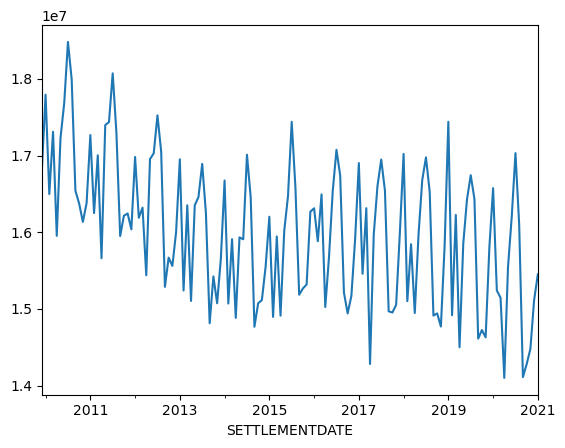

In [126]:
dem_daily.sum(axis=1).resample("M").sum().plot()

In [127]:
1.5e7 / 1000

15000.0

Write

In [128]:
dem_daily.to_csv(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_20091202-20210131.csv"
)

# EDA

Some time values are duplicated

In [30]:
q = df.loc[df.REGIONID == "QLD1"]

In [36]:
q.loc[q.index.duplicated()]

,REGIONID,TOTALDEMAND
SETTLEMENTDATE,,
2016-09-01 00:30:00,QLD1,5561.56
2016-09-01 01:00:00,QLD1,5380.54
2016-09-01 01:30:00,QLD1,5223.33
2016-09-01 02:00:00,QLD1,5110.12
2016-09-01 02:30:00,QLD1,5051.31
...,...,...
2016-09-07 22:00:00,QLD1,6284.30
2016-09-07 22:30:00,QLD1,6114.46
2016-09-07 23:00:00,QLD1,6070.07


In [45]:
q = q.loc[~q.index.duplicated()]
q

,REGIONID,TOTALDEMAND
SETTLEMENTDATE,,
2009-12-01 00:30:00,QLD1,5723.40
2009-12-01 01:00:00,QLD1,5532.81
2009-12-01 01:30:00,QLD1,5415.17
2009-12-01 02:00:00,QLD1,5270.51
2009-12-01 02:30:00,QLD1,5206.92
...,...,...
2021-01-31 22:00:00,QLD1,7028.43
2021-01-31 22:30:00,QLD1,6871.32
2021-01-31 23:00:00,QLD1,6684.62


In [13]:
pd.date_range("2009-12-01 00:30:00", "2021-02-01 00:00:00", freq="30min")

DatetimeIndex(['2009-12-01 00:30:00', '2009-12-01 01:00:00',
               '2009-12-01 01:30:00', '2009-12-01 02:00:00',
               '2009-12-01 02:30:00', '2009-12-01 03:00:00',
               '2009-12-01 03:30:00', '2009-12-01 04:00:00',
               '2009-12-01 04:30:00', '2009-12-01 05:00:00',
               ...
               '2021-01-31 19:30:00', '2021-01-31 20:00:00',
               '2021-01-31 20:30:00', '2021-01-31 21:00:00',
               '2021-01-31 21:30:00', '2021-01-31 22:00:00',
               '2021-01-31 22:30:00', '2021-01-31 23:00:00',
               '2021-01-31 23:30:00', '2021-02-01 00:00:00'],
              dtype='datetime64[ns]', length=195840, freq='30T')

### This figure now matches that directly from AEMO

/jobfs/95780661.gadi-pbs/ipykernel_3851824/2949094144.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (q.loc["2017-01"].resample("1H").mean()).plot(ylim=(0, 10000))


<AxesSubplot: xlabel='SETTLEMENTDATE'>

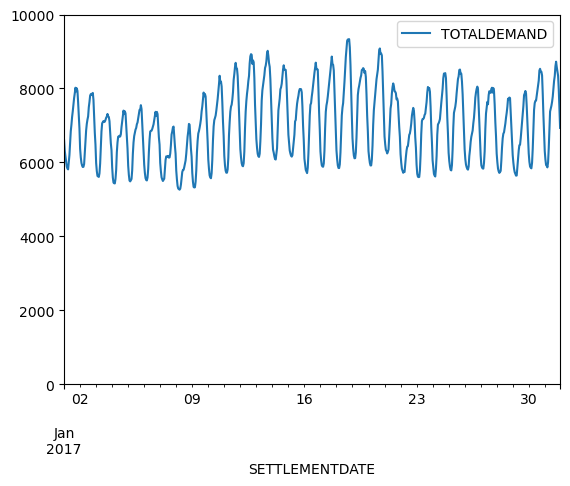

In [46]:
(q.loc["2017-01"].resample("1H").mean()).plot(ylim=(0, 10000))

<AxesSubplot: xlabel='SETTLEMENTDATE'>

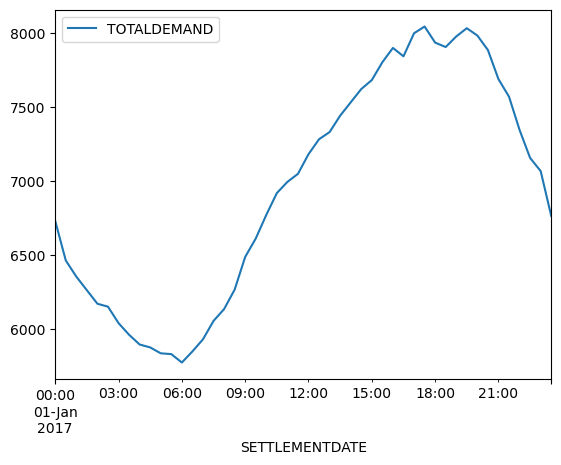

In [47]:
(q.loc["2017-01-01"]).plot()